# Qualité de l'air en bretagne

__Données__

téléchargement des données : <br>
[Indices qualité de l'air](https://data.airbreizh.asso.fr/geoserver/ind_bretagne_agglo/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=ind_bretagne_agglo:ind_bretagne_agglo&outputFormat=csv)
[Polution aux particules fines](https://data.airbreizh.asso.fr/geoserver/mes_bretagne_journalier_poll_princ/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=mes_bretagne_journalier_poll_princ:mes_bretagne_journalier_pm10&outputFormat=csv)
[Pollution au monoxyde de carbone](https://data.airbreizh.asso.fr/geoserver/mes_bretagne_journalier_poll_princ/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=mes_bretagne_journalier_poll_princ:mes_bretagne_journalier_co&outputFormat=csv)

__Métadonnées__

Description des champs :
- lib_zone : Nom du département concerné par les épisodes de pollution.
- date_ech : Date d'échéance de l'alerte.
- geom : Géolocalisation du centre du département en projection Lambert 93 (EPSG : 2154).
            

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyproj

sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 1.5})

## Préparation du datatset

### chargement des données

In [2]:
dftemp = pd.read_csv("ind_bretagne_agglo.csv", sep=",")
print(dftemp.shape)
dftemp.head(2)

(2547, 15)


,FID,date_ech,valeur,qualif,source,type_zone,code_zone,lib_zone,val_no2,val_so2,val_o3,val_pm10,val_pm25,geom,couleur
0,ind_bretagne_agglo.fid--15c6355_17743580ab0_-55da,2021-01-01T10:00:00,3,Bon,Air Breizh,EPCI,200069409,CA Saint-Brieuc Armor,0,0,0,0,0,POINT (269153.2682993477 6832824.934141148),#99E600
1,ind_bretagne_agglo.fid--15c6355_17743580ab0_-55d9,2021-01-01T10:00:00,3,Bon,Air Breizh,EPCI,200067932,CA Golfe du Morbihan - Vannes,0,0,0,0,0,POINT (269961.1106939723 6746307.8992528645),#99E600


### Analyse du Dataset 

In [3]:
dftemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FID        2547 non-null   object
 1   date_ech   2547 non-null   object
 2   valeur     2547 non-null   int64 
 3   qualif     2547 non-null   object
 4   source     2547 non-null   object
 5   type_zone  2547 non-null   object
 6   code_zone  2547 non-null   int64 
 7   lib_zone   2547 non-null   object
 8   val_no2    2547 non-null   int64 
 9   val_so2    2547 non-null   int64 
 10  val_o3     2547 non-null   int64 
 11  val_pm10   2547 non-null   int64 
 12  val_pm25   2547 non-null   int64 
 13  geom       2547 non-null   object
 14  couleur    2547 non-null   object
dtypes: int64(7), object(8)
memory usage: 298.6+ KB


In [4]:
print(len(dftemp['FID'].unique()), "valeurs uniques dans FID \n")
for i in ['valeur', 'qualif', 'source', 'type_zone', 'code_zone', 'lib_zone', 'geom', 'couleur']:
    print(len(dftemp[i].unique()), "valeurs uniques dans", i, ":", dftemp[i].unique(), "\n")

2547 valeurs uniques dans FID 

7 valeurs uniques dans valeur : [3 2 4 5 6 7 8] 

5 valeurs uniques dans qualif : ['Bon' 'Très bon' 'Moyen' 'Médiocre' 'Mauvais'] 

1 valeurs uniques dans source : ['Air Breizh'] 

1 valeurs uniques dans type_zone : ['EPCI'] 

7 valeurs uniques dans code_zone : [200069409 200067932 200068120 243500139 243500782 242900314 200042174] 

7 valeurs uniques dans lib_zone : ['CA Saint-Brieuc Armor' 'CA Golfe du Morbihan - Vannes'
 'CA Quimper Bretagne Occidentale' 'Rennes Métropole'
 'CA du Pays de Saint-Malo (Saint-Malo Agglomération)' 'Brest Métropole'
 'CA Lorient'] 

7 valeurs uniques dans geom : ['POINT (269153.2682993477 6832824.934141148)'
 'POINT (269961.1106939723 6746307.8992528645)'
 'POINT (172753.63056731108 6795400.543816281)'
 'POINT (349555.0070453745 6789093.386528317)'
 'POINT (338719.75810268405 6844013.788199687)'
 'POINT (147878.22420658765 6837175.794037035)'
 'POINT (229772.04043578357 6768639.926683848)'] 

7 valeurs uniques dans couleur

La pemière colone `FID`, qui correspond à un identifiant unique, sera supprimée.

La colonne `date_ech` sera conservée puique nous voulons évaluer l'évolution de la qualité de l'air au cours du temps. On retraitera simplement son format pour améliorer sa lisibilité.

Les colonnes `source` et `type_zone` contiennent une seule valeur et seront donc supprimées.

Le lien entre `code_zone`, `lib_zone`, et `geom` peuvent être exploité dans une table à part - on ne gardera que le code_zone, qui sera encodé, dans le dataframe principal.
Il en va de même pour `valeur`, `qualif` et `couleur`. On ne conservera que valeur. 

Le colonnes dont le nom commence par `val_` sont à conserver, car il s'agit des concentration en poluants, donc des données que nous voulons analyser. Cependant, près examen rapide du fichier CSV, on se rend compte que les mesures de `val_so2` et `val_pm25` ne sont pas renseignées. On étudiera donc les trois autres.

In [5]:
# liste des valeurs cibles
val_cibles = ['val_no2', 'val_o3', 'val_pm10']

### Retraitement des données et création de dataframes de travail

#### Création des tableaux annexes

##### Encodage de la variable qualitative (lib_zone)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()

dftemp['zone'] = le.fit_transform(dftemp['lib_zone'])

In [53]:
# Création d'un tableau de correspondance entre code_zone, lib_zone, et geom
liste_codes = dftemp.code_zone.unique()
tmp = []
for code in liste_codes :
    tmp.append(dftemp.code_zone.eq(code).idxmax())

df_zones = pd.DataFrame(dftemp[['code_zone', 'zone', 'lib_zone', 'geom']].iloc[tmp])


# Même chose pour les valeurs et les couleurs :
liste_codes = dftemp.valeur.unique()
tmp = []
for code in liste_codes :
    tmp.append(dftemp.valeur.eq(code).idxmax())
df_valeurs = pd.DataFrame(dftemp[['valeur', 'qualif', 'couleur']].iloc[tmp]).reset_index().drop(["index"], axis=1)

In [54]:
df_zones=df_zones.set_index("zone")
df_zones

,code_zone,lib_zone,geom
zone,,,
4,200069409,CA Saint-Brieuc Armor,POINT (269153.2682993477 6832824.934141148)
1,200067932,CA Golfe du Morbihan - Vannes,POINT (269961.1106939723 6746307.8992528645)
3,200068120,CA Quimper Bretagne Occidentale,POINT (172753.63056731108 6795400.543816281)
6,243500139,Rennes Métropole,POINT (349555.0070453745 6789093.386528317)
5,243500782,CA du Pays de Saint-Malo (Saint-Malo Aggloméra...,POINT (338719.75810268405 6844013.788199687)
0,242900314,Brest Métropole,POINT (147878.22420658765 6837175.794037035)
2,200042174,CA Lorient,POINT (229772.04043578357 6768639.926683848)


In [55]:
df_valeurs=df_valeurs.set_index("valeur")
#df_valeurs.sortby(index)
df_valeurs.sort_values(by="valeur")

,qualif,couleur
valeur,,
2,Très bon,#5CCB60
3,Bon,#99E600
4,Bon,#C3F000
5,Moyen,#FFFF00
6,Médiocre,#FFD100
7,Médiocre,#FFAA00
8,Mauvais,#FF0000


#### Création du tableau principal 

##### Retraitement de la date

In [11]:
dftemp['date_ech'] = pd.to_datetime(dftemp['date_ech'])

##### Ajout des dates de confinement

En plus d'élaborer des outils pour suivre et analyser la pollution atmosphérique à l'échelle de la région, on souhaite également connaître l'impact du confinement sur la pollution.

Nous allons donc intégrer les dtates de confinement dans le dataset.

In [12]:
# premier confinement strict, du 17 mars à 12 h au 11 mai 2020 (non inclus)
debut_conf1 = pd.to_datetime("2020-03-17 12:00:00")
fin_conf1 = pd.to_datetime("2020-05-11 00:00:00")
# second confinement, moins strict, du 30 octobre 2020 au 15 décembre 2020 (non inclus)
debut_conf2 = pd.to_datetime("2020-10-30 18:00:00")
fin_conf2 = pd.to_datetime("2020-12-15 00:00:00")

In [13]:
dftemp['confnt'] = np.zeros(len(dftemp)).astype(int)
dftemp.loc[ 
    (dftemp['date_ech'] <= fin_conf2), 
    'confnt'] = 1
dftemp.loc[ 
    (dftemp['date_ech'] <= debut_conf2), 
    'confnt'] = 0
dftemp.loc[ 
    (dftemp['date_ech'] <= fin_conf1), 
    'confnt'] = 1
dftemp.loc[ 
    (dftemp['date_ech'] <= debut_conf1), 
    'confnt'] = 0

##### Création du DataFrame

In [36]:
df = pd.concat([dftemp['date_ech'], dftemp['lib_zone'], dftemp['confnt'], dftemp['valeur'], dftemp[val_cibles]], axis=1)
df.tail(8)

,date_ech,lib_zone,confnt,valeur,val_no2,val_o3,val_pm10
2539,2020-01-02 10:00:00,CA Lorient,1,3,1,3,3
2540,2020-01-01 10:00:00,Rennes Métropole,1,3,2,2,3
2541,2020-01-01 10:00:00,CA Golfe du Morbihan - Vannes,1,3,2,3,2
2542,2020-01-01 10:00:00,CA Saint-Brieuc Armor,1,3,2,2,3
2543,2020-01-01 10:00:00,CA Quimper Bretagne Occidentale,1,3,2,3,2
2544,2020-01-01 10:00:00,CA Lorient,1,3,2,3,2
2545,2020-01-01 10:00:00,CA du Pays de Saint-Malo (Saint-Malo Aggloméra...,1,3,1,2,3
2546,2020-01-01 10:00:00,Brest Métropole,1,3,2,3,2


## 2. Visualisation des données

### Analyse du dataset

Il est tout d'abord intéressant de visualiser la répartition des données, en utilisant des diagrammes de répartition ou des boîtes à moustaches.


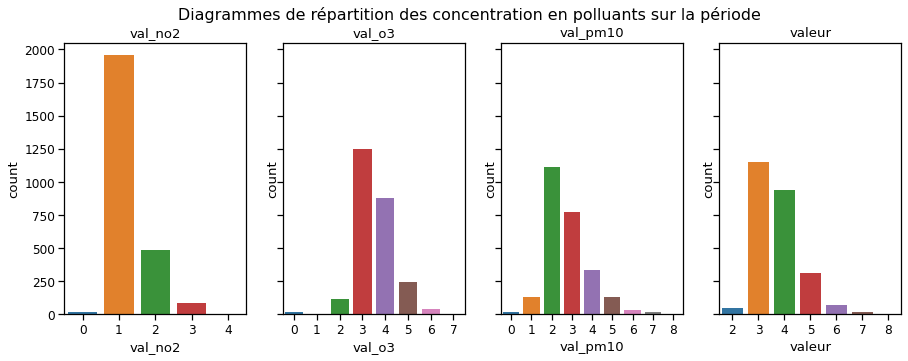

In [30]:
vtemp = val_cibles + ['valeur']

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Diagrammes de répartition des concentration en polluants sur la période')

for i, val in enumerate(vtemp):
    sns.countplot(ax=axes[i], x=val, data=df)
    axes[i].set_title(val)

plt.savefig("images/diagrammes")

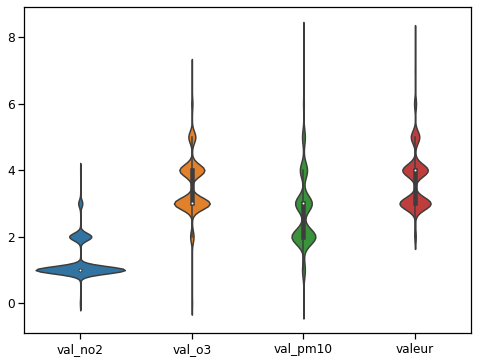

In [31]:
plt.figure(figsize=(8,6))
sns.violinplot(data=df[vtemp])
plt.savefig("images/violin")

La distribution des valeurs ci-dessus est unimodale, avec une asymétrie à gauche. Il est également intéressant de noter que la concentration en dioxyde d'azote (NO2) présente varie peu et présente presque 70% du temps la valeur 1.

Il serait maintenant intéressant de voir si les variations des concentration en polluants on un lien entre elles et avec celle l'indice de qualité de l'air.

Comme nos variables sont discrètes, la visualisation des nuages de points ne donnera rien d'intéressant. Par contre, on peut utiliser une matrice de corrélation, ou "Heatmap" pour mettre en avant les liens.

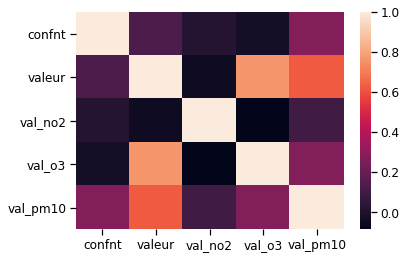

In [32]:
sns.heatmap(df.corr())
plt.savefig("images/heatmap_global")

Les corrélations qui apparaîssent nettement sont celles entre la valeur de l'indice de la qualité de l'air (bon / moyen / médiocre...) et les concentrations en ozone (O3) et en dioxyde d'azote (NO2). La correlation de ces deux valeurs entre elles n'est par contre pas nette.

Par ailleurs, cette carte indique qu'il n'y aurait pas, a première vue, de lien de cause à effet entre confinement et indice de la qualité de l'air.

On peut voir tout cela plus en détails dans la matrice de corrélation ci-dessous.

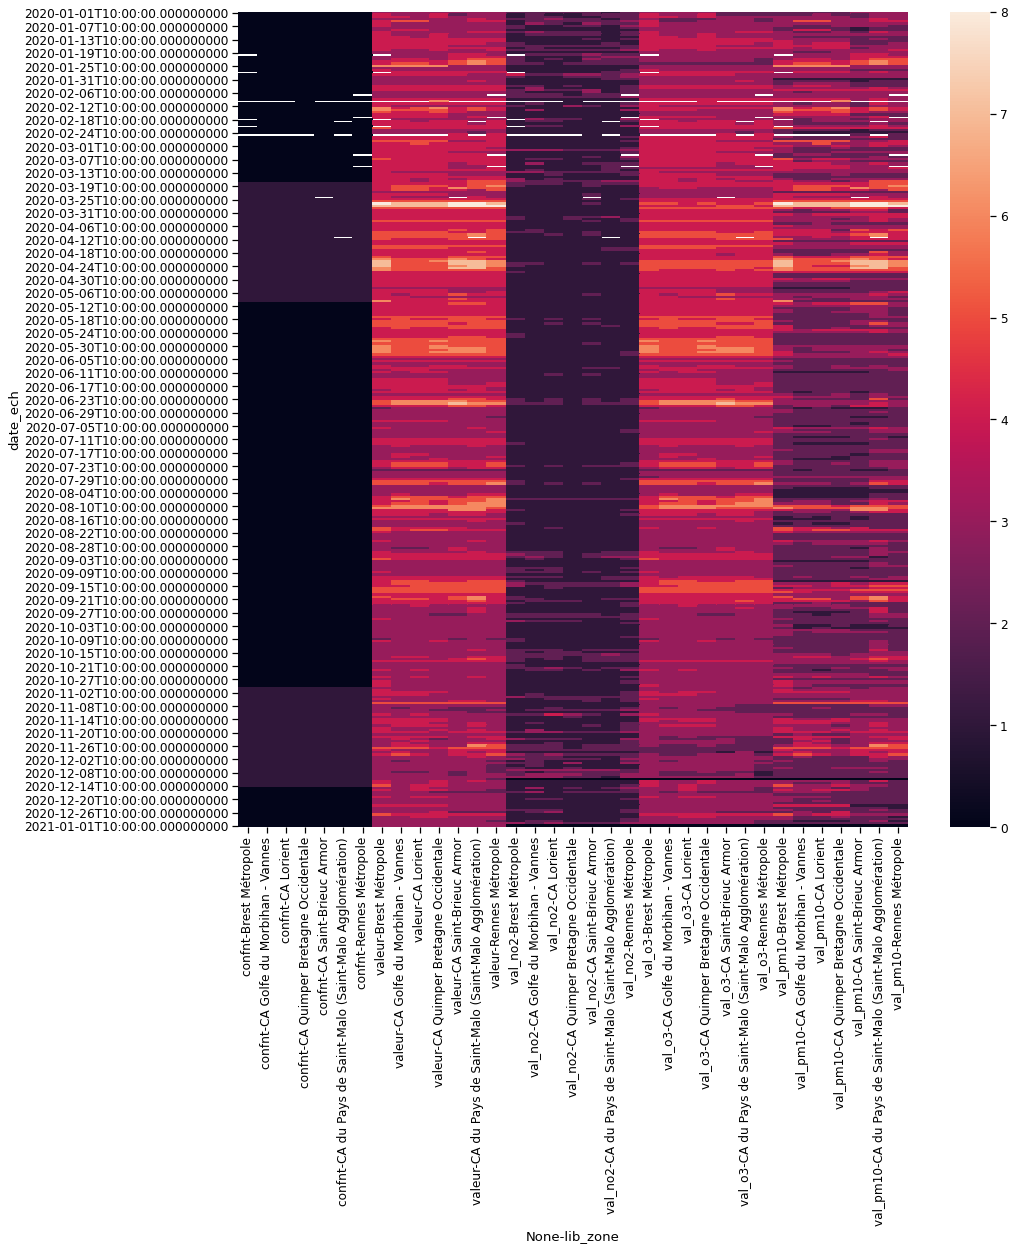

In [33]:
f, ax = plt.subplots(figsize=(15, 15))
data = df.pivot("date_ech", "lib_zone", ['confnt', 'valeur', 'val_no2', 'val_o3', 'val_pm10'])
sns.heatmap(data, ax=ax)
plt.savefig("images/heatmap_detailed")

Cette carte très complète nous montre les valeurs de l'indice de la qualité de l'air et des concentrations en polluants pour les différentes zones et à travers le temps. Afin d'en faciliter la lecture, on a également choisi d'y faire  apparaître les périodes de confinement.

Il en ressort que :
- les correlations définies à l'aide de la première matrice sont confirmées. La concentration en Ozone (O3) particulièrement évolue de manière très similaire à l'indice de la qualité de l'air. Par ailleurs, on assiste à une importante dégradation la qualification de l'indice lors des pics de pollution aux particules fines (voir dans la matrice ci-dessus les pics de fin mars et mi-avril 2020). On peut en conclure que __les pollutions à l'ozone et aux particules fines sont déterminantes dans la définition de l'indice de la qualité de l'air__.
- On observe que __les deux pics de polution en PM10 et O3 les plus importants de 2020 (donc dégradation de l'indice, comme vu ci-dessus) se situent tous les deux pendant le premier confinement__. On peut supposer que les pollutions domestiques ont remplacé celles du traffic routier en termes d'émission de particules fines et de production d'ozone. Ces données seraient également à croiser avec des données météorologiques, les précipitations favorisant par exemple la dispertion des particules fines, et l'ensoleillement la production d'ozone, etc.
- La concentration en dioxyde d'azote (NO2) varie effectivement peu, et son augmentation ne semble pas liée au confinement, mais peut-être __plutôt à la saison__ : basse en été, augmentations épisodiques en hiver. 
- Enfin, la répartition entre départements est globalement homogène.


## Préparation des données pour la cartographie 

In [60]:
# on va retraiter le dataframe df_zone créé dnas la prmeière partie
df_zones['geom']

zone
4     POINT (269153.2682993477 6832824.934141148)
1    POINT (269961.1106939723 6746307.8992528645)
3    POINT (172753.63056731108 6795400.543816281)
6     POINT (349555.0070453745 6789093.386528317)
5    POINT (338719.75810268405 6844013.788199687)
0    POINT (147878.22420658765 6837175.794037035)
2    POINT (229772.04043578357 6768639.926683848)
Name: geom, dtype: object

In [61]:
#import pyproj
import warnings
warnings.filterwarnings('ignore')

lambert93 = pyproj.CRS('epsg:2154')
wgs84 = pyproj.CRS('epsg:4326')

In [62]:
x,y = pyproj.transform(lambert93, wgs84, 269153.2682993477, 6832824.934141148) #test
print(x, y) #test

48.45243390946135 -2.8320587272323423


In [63]:
dftemp.loc[ 
    (dftemp['date_ech'] <= fin_conf2), 
    'confnt'] = 1

df_zones['Longitude'] = np.zeros(len(df_zones))
df_zones['Latitude'] = np.zeros(len(df_zones))

for ind, val, in df_zones['geom'].iteritems():
    long = val.split('(')[1].split(' ')[0]
    lat = val.split('(')[1].split(' ')[1].split(')')[0]
    x,y = pyproj.transform(lambert93, wgs84, long, lat)
    df_zones.loc[
        (df_zones.index == ind), 'Longitude'] = y
    df_zones.loc[
        (df_zones.index == ind), 'Latitude'] = x

df_zones

,code_zone,lib_zone,geom,Longitude,Latitude
zone,,,,,
4,200069409,CA Saint-Brieuc Armor,POINT (269153.2682993477 6832824.934141148),-2.832059,48.452434
1,200067932,CA Golfe du Morbihan - Vannes,POINT (269961.1106939723 6746307.8992528645),-2.736238,47.676516
3,200068120,CA Quimper Bretagne Occidentale,POINT (172753.63056731108 6795400.543816281),-4.085219,48.045952
6,243500139,Rennes Métropole,POINT (349555.0070453745 6789093.386528317),-1.711339,48.108092
5,243500782,CA du Pays de Saint-Malo (Saint-Malo Aggloméra...,POINT (338719.75810268405 6844013.788199687),-1.902423,48.595360
0,242900314,Brest Métropole,POINT (147878.22420658765 6837175.794037035),-4.470520,48.399641
2,200042174,CA Lorient,POINT (229772.04043578357 6768639.926683848),-3.293846,47.849403


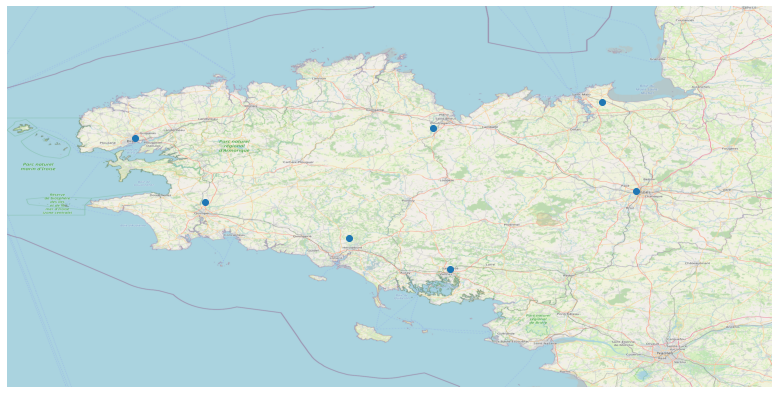

In [69]:
plt.figure(figsize=(15,7))
bretagne = plt.imread("map.png")
plt.scatter(df_zones["Longitude"], df_zones["Latitude"])
plt.imshow(bretagne, zorder=0, extent =[-5.175,-0.967, 47.029, 49.124 ])
plt.axis('off')
plt.savefig("images/carte")